# Miguel Suarez


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as sk_metrics
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

In [ ]:
#Importing Titanic Data
#csv = '/content/drive/MyDrive/Colab Notebooks/Titanic-Dataset.csv'
csv = 'train.csv'
data = pd.read_csv(csv)


In [ ]:
#Initial examination of data
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
#Turning data into dataframe and filling in missing age values with median age
df = pd.DataFrame(data)
median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)

# Filling null values in embarked with 'Not Known' (only 2 not known out of 891)
df['Embarked'] = df['Embarked'].fillna('Not Known')

#Excluding cabin from df for purposes of this analysis (less than 23% of records available ) and ticket as there are too many unique values for significant analysis.
#As well I am dropping name as it serves no purpose for the model creation

df = df.drop(['Cabin'], axis=1)

df = df.drop(['Ticket'], axis=1)

df = df.drop(['Name'], axis=1)

#Examining that changes took place
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


#### One-Hot encoding the values to ensure I am able to analyze the data accordingly

In [ ]:
#One-hot encoding sex feature
df['Sex'] = df['Sex'].map({'male': 1, 'female': 2})

#Finding the unique values for embarked
print(f"The unique values are: {df['Embarked'].unique()}")

#One-hot encoding unique values for embarked
df['Embarked'] = df['Embarked'].map({'S': 1, 'C': 2,'Q': 3, 'Not Known': 4})

#Examining that changes took place
df.info()

The unique values are: ['S' 'C' 'Q' 'Not Known']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


####I believe that passengers who paid higher fares for their tickets may have had better access to lifeboats or rescue priority. Grouping fares into bins can help clarify seeing this as a factor if necessary. Furthermore, it is most likely that children were a priority in assigning the life boats, and consequently, it would be important to see if this actually played out in real life.



In [ ]:
#Creating Bins for Price ranges between 0 (-1 is below 0) and 600. Labeling these as low, medium and high fare bins (Changed from previous to reflect 0 = Low, 1 = Medium, 2= High)
bins = [-1, 75, 150, 600]
labels = [1, 2, 3]
df['FareBin'] = pd.cut(df['Fare'], bins, labels=labels)

#Creating condition for whether a person is a child or not (True = 1, False =0)
df['IsChild'] = np.where(df['Age'] < 18, 1, 0)

#Examining that changes took place
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Sex          891 non-null    int64   
 4   Age          891 non-null    float64 
 5   SibSp        891 non-null    int64   
 6   Parch        891 non-null    int64   
 7   Fare         891 non-null    float64 
 8   Embarked     891 non-null    int64   
 9   FareBin      891 non-null    category
 10  IsChild      891 non-null    int64   
dtypes: category(1), float64(2), int64(8)
memory usage: 70.7 KB


In [ ]:
#@title Tuning to Test for Survived and Normalizing Data

#Dividing dataset and taking out the survived feature to test for it
data_train = df.sample(frac=0.8, random_state=1)
data_test = df.drop(data_train.index)
x_train = data_train.drop("Survived", axis=1)
y_train = data_train["Survived"]
X_test = data_test.drop("Survived", axis=1)
y_test = data_test["Survived"]

#Converting to Tensorflow float for all features
X_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test, y_test = tf.convert_to_tensor(X_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

#Normalized data per instructions
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))


In [ ]:
#@title Model Creation and Prediction

#Creating model and compiling it
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=1000, batch_size=25, verbose=0)

# Model makes the predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

6/6 [==============================] - 0s 3ms/step


Model Accuracy: 0.797752808988764


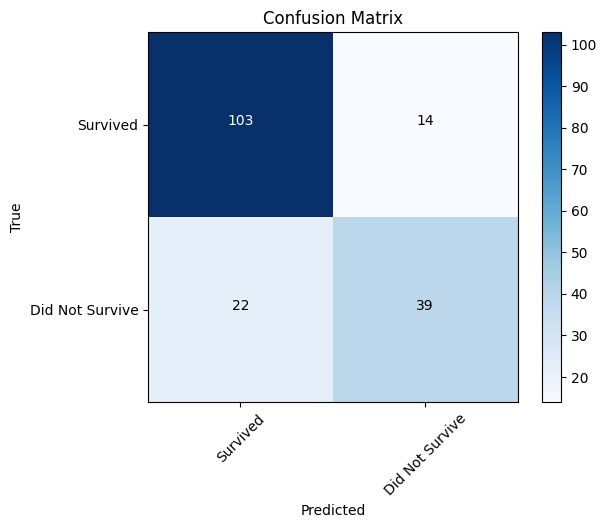

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       117
         1.0       0.74      0.64      0.68        61

    accuracy                           0.80       178
   macro avg       0.78      0.76      0.77       178
weighted avg       0.79      0.80      0.79       178



In [ ]:
#@title Confusion Matrix and Accuracy

# Calculating the accuracy and confusion matrix
accuracy = sk_metrics.accuracy_score(y_test, y_pred)
confusion = sk_metrics.confusion_matrix(y_test, y_pred)
class_report = sk_metrics.classification_report(y_test, y_pred)

# Printing the model's accuracy
print("Model Accuracy:", accuracy)

# Visualization that shows the the confusion matrix
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ["Survived", "Did Not Survive"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True")
    plt.xlabel("Predicted")

# Plotting the confusion matrix
plt.figure()
plot_confusion_matrix(confusion)
plt.show()

print(class_report)

In [ ]:
#@title Examining the Importance of the Features

# Getting the weights (coefficients) from the model's Dense layer
weights = model.layers[0].get_weights()[0]

# Calculating absolute value of the model's weights
abs_weights = np.abs(weights)

# Get the indices of the top 5 features
top_feature_indices = np.argsort(abs_weights.flatten())[-5:]

# Get the column names corresponding to the top feature indices
top_features = x_train.columns[top_feature_indices]

print("Top 5 Features:", top_features)

Top 5 Features: Index(['Embarked', 'Pclass', 'Age', 'Fare', 'PassengerId'], dtype='object')


#Summary and Conclusions

#### Per the conclusions from the model above, it is great to see that the model had an 80% accuracy in predictions. After testing hyperparameters and epoch count, I determined a logical conclusion that the model improved when there were more epochs, but only by a small margin when increasing iterations by orders of magnitude from 100 and on ( I left it at 1) . It is also a shock that embarked was a great predicting factor in the overall model, as it was not expected that this embarkation port had much significance first. Further examination of the feature would show that those who embarked in certain ports would often one class and age of passangers, which aligns to the previous data visualization from last class.

####Creating other features could help improve the accuracy of the model, one that could combine both embarkation place with other features or create a calculation for pclass. Nonetheless, in the presence of quite a bit of features, it can be challenging to create these. The model, nevertheless, was effective at predicting for most of the dataset.